In [1]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import os
from tqdm import tqdm
import cv2
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE
import seaborn as sns

In [2]:
#Read 1 Sample Image

img = cv2.imread("data/256x256_png_images/5_640805896.png",0)
img

array([[149, 156, 156, ...,   0,   0,   0],
       [151, 152, 160, ...,   0,   0,   0],
       [160, 160, 160, ...,   0,   0,   0],
       ...,
       [152, 150, 157, ...,   0,   0,   0],
       [156, 141, 152, ...,   0,   0,   0],
       [156, 155, 161, ...,   0,   0,   0]], dtype=uint8)

In [3]:
#Read tabular Metadata of each patient and image

metadata = pd.read_csv("data/train.csv")
metadata

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54701,1,9973,1729524723,R,MLO,43.0,0,0,0,1.0,0,C,49,False
54702,1,9989,63473691,L,MLO,60.0,0,0,0,NaN,0,C,216,False
54703,1,9989,1078943060,L,CC,60.0,0,0,0,NaN,0,C,216,False
54704,1,9989,398038886,R,MLO,60.0,0,0,0,0.0,0,C,216,True


In [4]:
#This function extracts pixels data for each image and transforms the values in a linear array.

def get_pixels_label(img_list, df):

    img_pixels = []
    y = []

    for file in tqdm(img_list):
        img = os.path.join("data/256x256_png_images/", file)
        
        #Get Image Pixels
        pixels = cv2.imread(img,0) #0 so that the image is read as gray scale
        pixels = cv2.resize(pixels, (64,64)) #Resize the image
        pixels = pixels.flatten().astype(float)
        img_pixels.append(pixels)

        #Get y-label
        file = file.split(".")[0] #Remove .png from file name
        patient = int(file.split("_")[0])
        image = int(file.split("_")[1])
        cancer_flag = df.loc[(df["patient_id"]==patient) & (df["image_id"]==image), 'cancer'].values[0]
        y.append(cancer_flag)

    return img_pixels, y

In [5]:
#Get names of all image files
img_list = os.listdir("data/256x256_png_images")

#Extract Pixel Values
X, y = get_pixels_label(img_list, metadata)

100%|██████████| 54706/54706 [02:10<00:00, 420.39it/s]


In [6]:
#Convert X and y into float values

X = np.array(X).astype(float)
y = np.array(y).astype(float)

In [7]:
#Split Data into Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

<Axes: ylabel='count'>

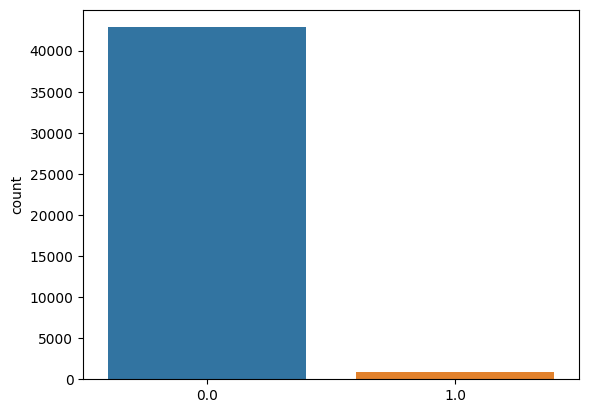

In [8]:
#Before Upsampling

sns.countplot(x = y_train.astype(str))

In [9]:
# Upsample data using SMOTE
upsampler = SMOTE(random_state=42)
X_train_upsampled, y_train_upsampled = upsampler.fit_resample(X_train, y_train)

<Axes: ylabel='count'>

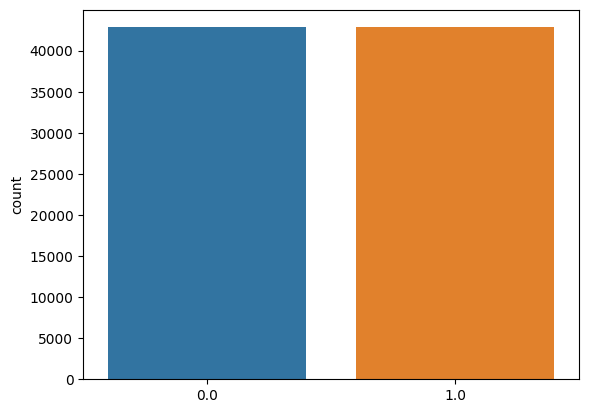

In [10]:
#After Upsampling

sns.countplot(x = y_train_upsampled.astype(str))

In [11]:
#Normalize Pixel Values

X_train_upsampled /= 255

In [12]:
#Run PCA

#Fit PCA on train data
variance_explained = 0.99
pca = PCA(n_components=variance_explained)
X_train_upsampled_pca = pca.fit_transform(X_train_upsampled)
X_test_pca = pca.transform(X_test)

In [13]:
pca.explained_variance_ratio_.sum()

0.9900078914318796

In [14]:
X_train_upsampled_pca.shape

(85676, 1716)

In [15]:
X_test_pca.shape

(10942, 1716)

In [16]:
#Fit KNN Classification model

model = KNeighborsClassifier(n_neighbors = 100)
model.fit(X_train_upsampled_pca, y_train_upsampled)
y_pred = model.predict(X_test_pca)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("F1-Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)

F1-Score:  0.0
Precision:  0.0
Recall:  0.0
Accuracy:  0.9786145128861269


In [17]:
#Fit Logistic Regression model

model = LogisticRegression(max_iter = 10000)
model.fit(X_train_upsampled_pca, y_train_upsampled)
y_pred = model.predict(X_test_pca)

f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print("F1-Score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Accuracy: ", accuracy)

F1-Score:  0.03515379786566228
Precision:  0.018957345971563982
Recall:  0.2413793103448276
Accuracy:  0.7190641564613416


/tmp/ipykernel_1233/1881029465.py:8: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(x = X_train_upsampled_pca_tsne[:,0], y = X_train_upsampled_pca_tsne[:,1], hue = y_train_upsampled, palette = sns.hls_palette(10), legend = 'full')


<Axes: >

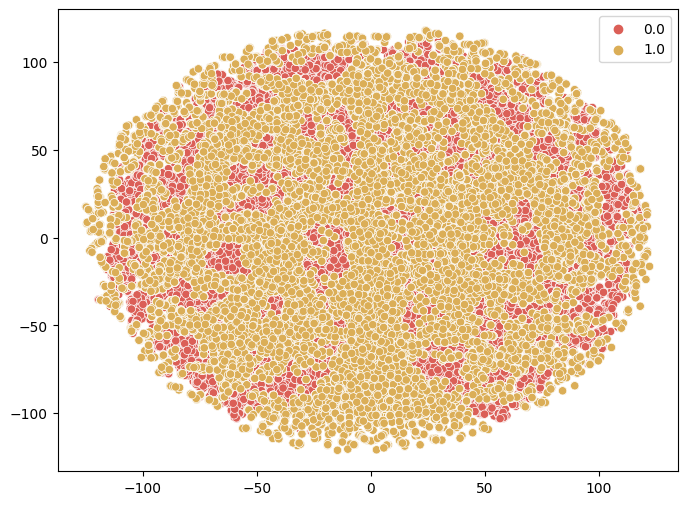

In [18]:
#Perform TSNE

from sklearn.manifold import TSNE

X_train_upsampled_pca_tsne = TSNE(n_components=2, perplexity=5, random_state=0).fit_transform(X_train_upsampled_pca)

plt.figure(figsize=(8,6))
sns.scatterplot(x = X_train_upsampled_pca_tsne[:,0], y = X_train_upsampled_pca_tsne[:,1], hue = y_train_upsampled, palette = sns.hls_palette(10), legend = 'full')